In [4]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import sys
import os
from skimage.color import rgb2gray
from skimage.transform import rescale, resize

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

In [5]:
import warnings
warnings.filterwarnings("ignore")

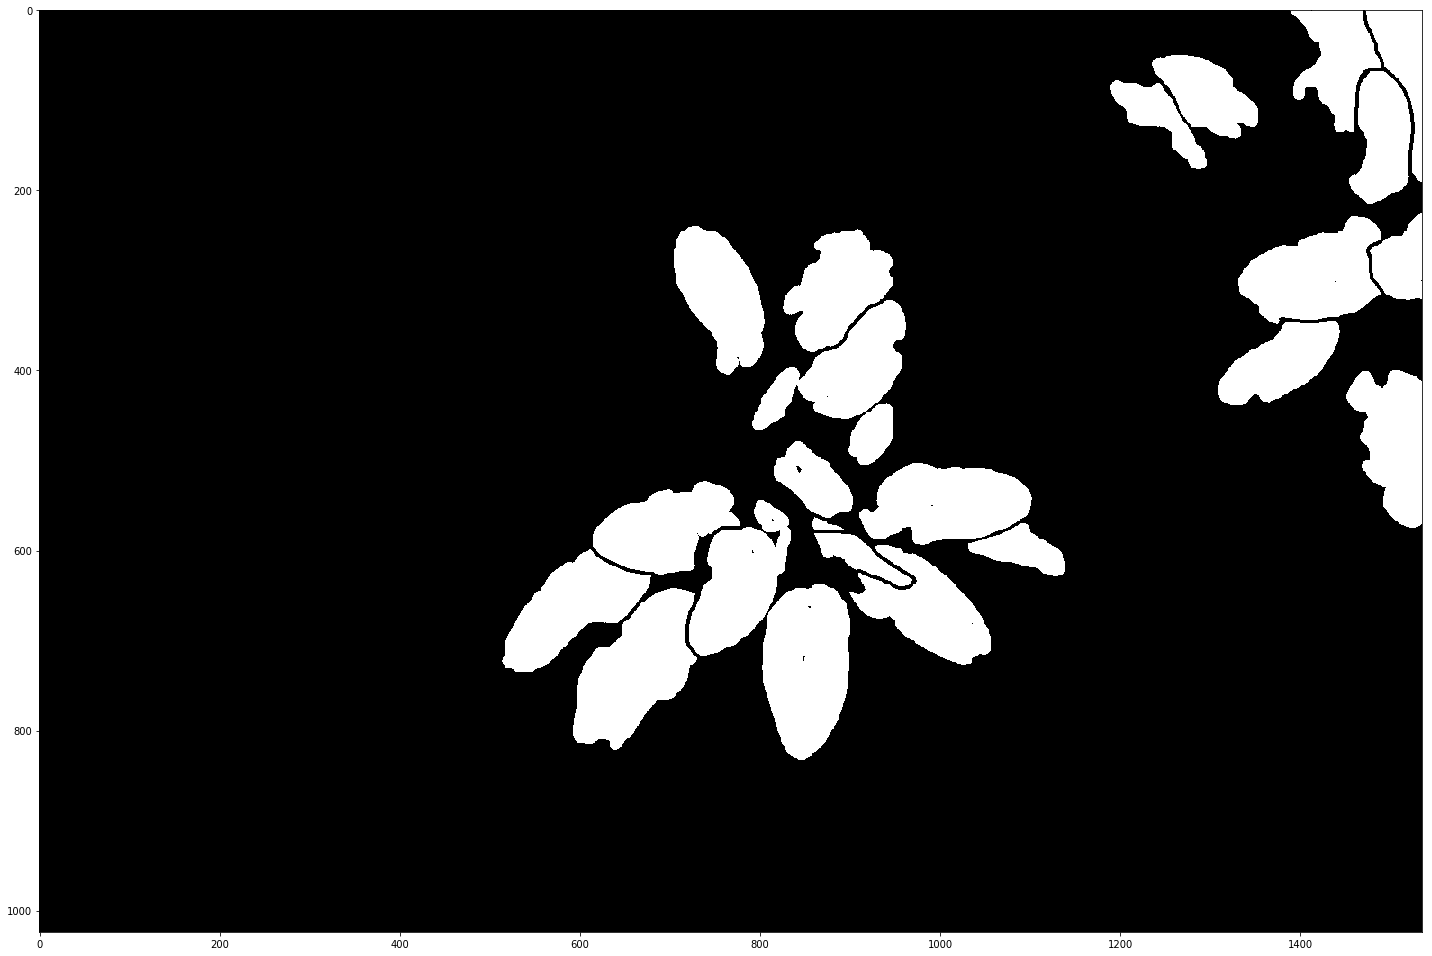

In [33]:
w = imread('../data/LabelingTool/test/a.png')
w = resize(w,(1024,1536))
test = w
plt.figure(figsize=(20,20))
imshow(w>0.5)

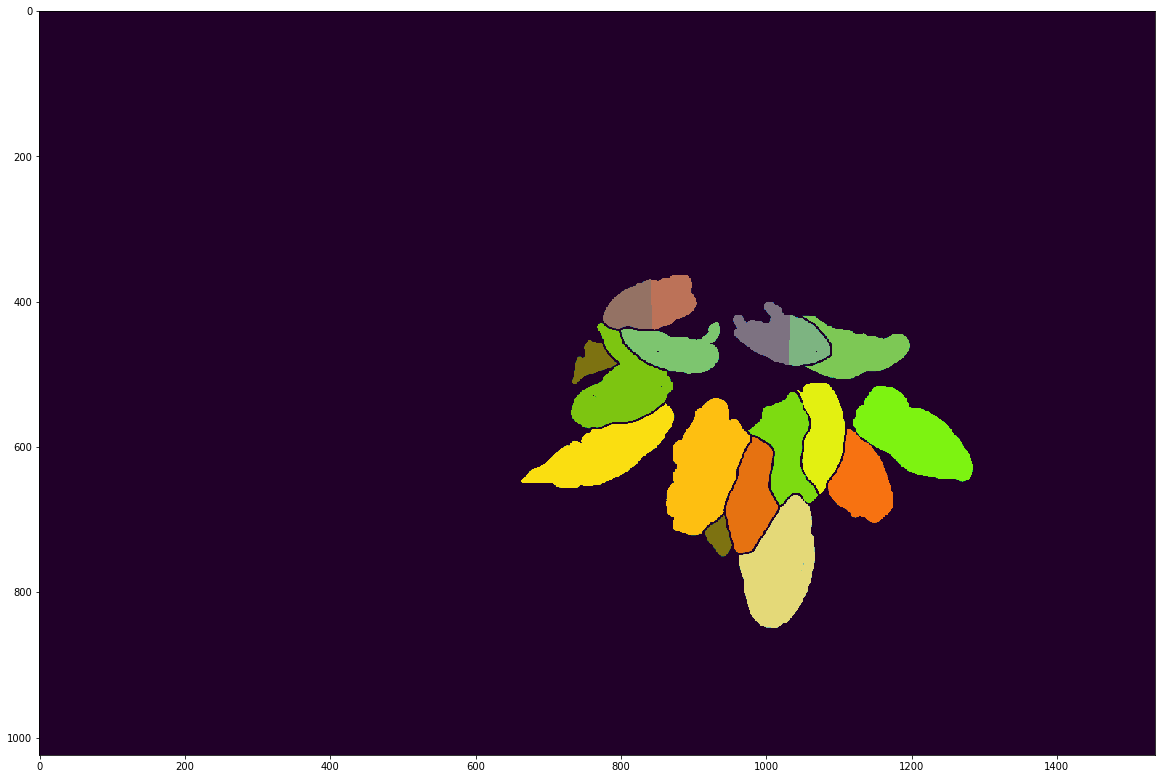

In [9]:
# http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html

def watershed_segmentation(prediction_image,threshold=0.90,footprint_size=(40,40)):
    from scipy import ndimage as ndi
    from skimage.morphology import watershed
    from skimage.feature import peak_local_max
    from skimage.draw import circle
    circle_img = np.zeros(footprint_size, dtype=np.uint8)
    rr, cc = circle(footprint_size[0]/2, footprint_size[1]/2,min(footprint_size)/2-2)
    circle_img[rr, cc] = 1
    
    # Now we want to separate the two objects in image
    # Generate the markers as local maxima of the distance to the background
    pred_logical = prediction_image>threshold
    distance = ndi.distance_transform_edt(pred_logical)
    local_maxi = peak_local_max(distance, indices=False, footprint=circle_img, labels=pred_logical)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=pred_logical)
    
    return distance, labels

distance, labels = watershed_segmentation(w>0.5,footprint_size=(100,100))

plt.figure(figsize=(20,20))
imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
imshow(w,alpha=0.5)

In [18]:
import skimage.measure
mask = w > 0.5
labels = skimage.measure.label(mask)
print(labels.shape, labels.dtype)
print("Unique values in labels:", np.unique(labels))

(1024, 1536) int64
Unique values in labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [19]:
import ipywidgets as widgets
@widgets.interact(label = list(np.unique(labels)))
def f(label):
    print(f"The connected component with label {label} contains {np.sum(labels == label)} pixels")
    plt.imshow(labels == label)

interactive(children=(Dropdown(description='label', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

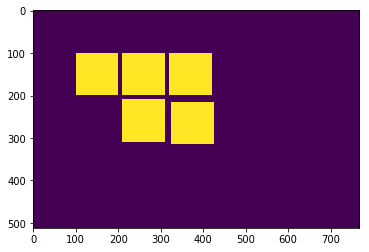

In [12]:
from skimage.draw import rectangle
w = np.zeros((SHAPE), dtype=np.uint8)
start = (1, 1)
extent = (3, 3)
rr, cc = rectangle((100,100), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
rr, cc = rectangle((100,210), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
rr, cc = rectangle((100,320), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
rr, cc = rectangle((210,210), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
rr, cc = rectangle((215,325), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
test = w
imshow(w)

1.9862071167439161

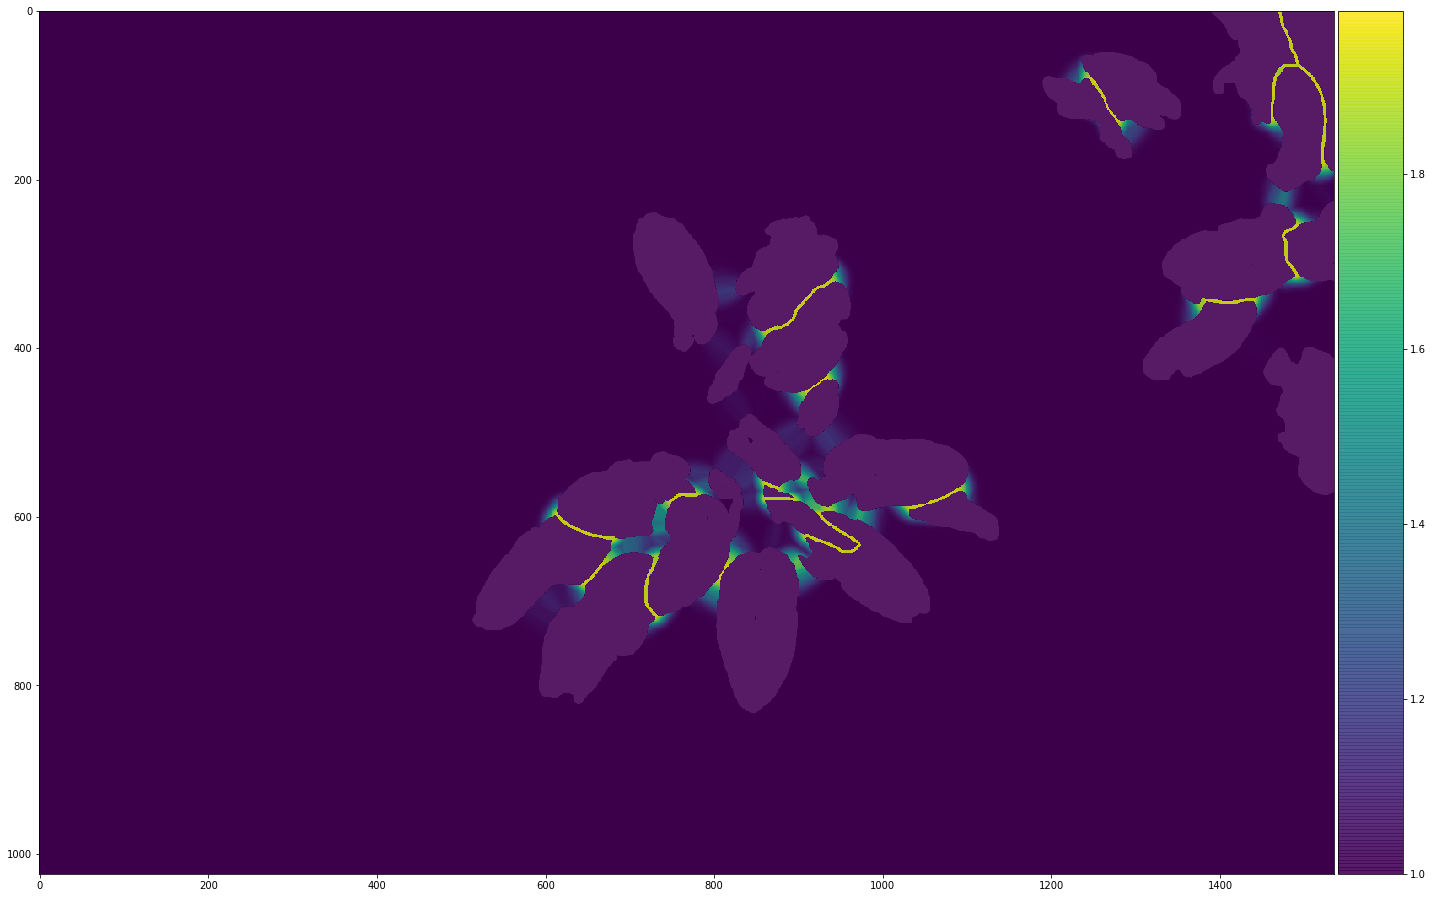

In [35]:
# https://stackoverflow.com/questions/50255438/pixel-wise-loss-weight-for-image-segmentation-in-keras

%matplotlib inline
import numpy as np
from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt

def unet_weight_map(y, wc=None, w0 = 50, sigma = 3):

    """
    Generate weight maps as specified in the U-Net paper
    for boolean mask.

    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    https://arxiv.org/pdf/1505.04597.pdf

    Parameters
    ----------
    mask: Numpy array
        2D array of shape (image_height, image_width) representing binary mask
        of objects.
    wc: dict
        Dictionary of weight classes.
    w0: int
        Border weight parameter.
    sigma: int
        Border width parameter.

    Returns
    -------
    Numpy array
        Training weights. A 2D array of shape (image_height, image_width).
    """
    y = y.astype(bool)
    labels = label(y)
    no_labels = labels == 0
    label_ids = sorted(np.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:,:,i] = distance_transform_edt(labels != label_id)
            
        distances = np.sort(distances, axis=2)
        d1 = distances[:,:,0]
        d2 = distances[:,:,1]
        w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

        if wc:
            class_weights = np.zeros_like(y)
            for k, v in wc.items():
                class_weights[y == k] = v
            w = w + class_weights
    else:
        w = np.zeros_like(y)
    return w

wc = {0: 1, # background
      1: 2  # objects
     }

w2 = unet_weight_map(test, wc=wc, w0 = 1, sigma = 12)

plt.figure(figsize=(20,20))
imshow(test)
imshow(w2,alpha=0.90)
w2.max()